# Exploring the ABIDE data

Francois sent over this data. I'm going to assume it's correlation networks for individuals, some of whom are ADS and some of whom are TD. I'm not sure which is diagnosis "1" and which is "2".

In [1]:
import scipy.io

In [4]:
data = scipy.io.loadmat('data/abide_connectivity.mat')

In [5]:
correlations = np.abs(data['correlation'])
diagnoses = data['diagnosis'] - 1
diagnoses = [bool(item) for item in diagnoses.flatten()]
n = correlations.shape[1]
N = correlations.shape[0]

print('Atlas size is {}, with {} brains in the dataset.'.format(n,N))

Atlas size is 116, with 871 brains in the dataset.


In [6]:
print('Average correlation is {:.03f}'.format(np.mean(correlations)))

Average correlation is 0.277


In [7]:
TD = len(diagnoses) - sum(diagnoses)
ADS = sum(diagnoses)
print('There are {} TD brains and {} ADS brains.'.format(TD,ADS))

There are 403 TD brains and 468 ADS brains.


In [8]:
ASD_array = correlations[diagnoses,:,:]
n,_,_ = ASD_array.shape

In [9]:
ASD_list = list(ASD_array)

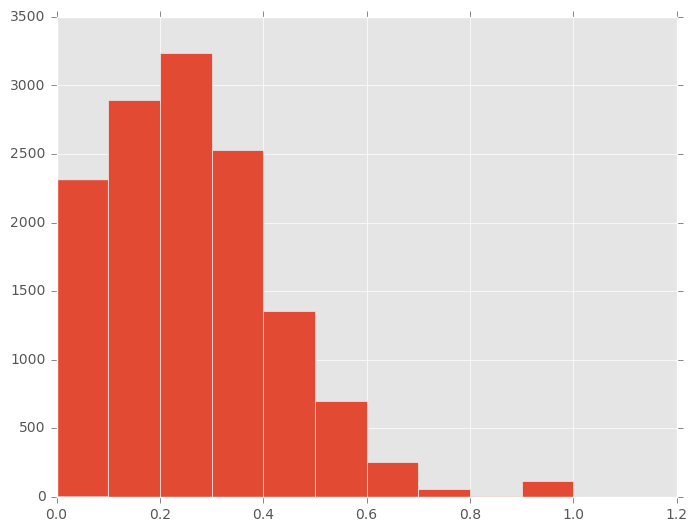

In [10]:
plt.hist(correlations[1,:,:].flatten());

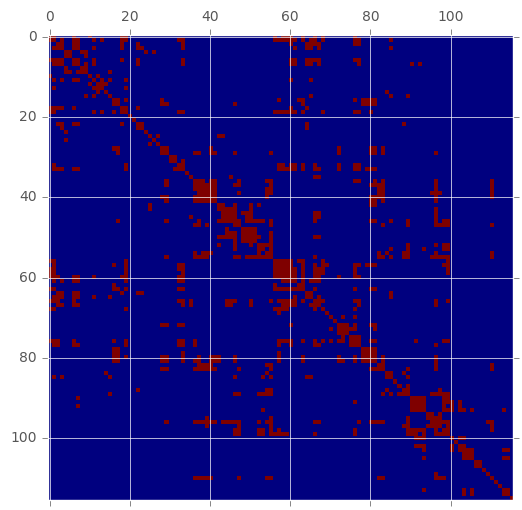

In [11]:
T = 0.5
plt.matshow(correlations[1,:,:] > T);

## Examining the community structure

We want to know how strong the community structure is in these graphs. To that end, we need to 

1. Cluster the graph(s) into communities (should be the same for all brains)
2. Check the average in- vs out-degree for these communities
3. See how closely these correspond to the associated stochastic blockmodels (i.e. check degree distributions)

The goal is to figure out if an SBM-like model will be useful in analyzing brain networks.

We're using the community detection algorithm from [here](http://perso.crans.org/aynaud/communities/), with source found [here](https://github.com/taynaud/python-louvain/) (link to original paper is [here](https://arxiv.org/pdf/0803.0476.pdf)).

In [12]:
import community
adj_mat = (correlations[1,:,:] > T).astype(int)

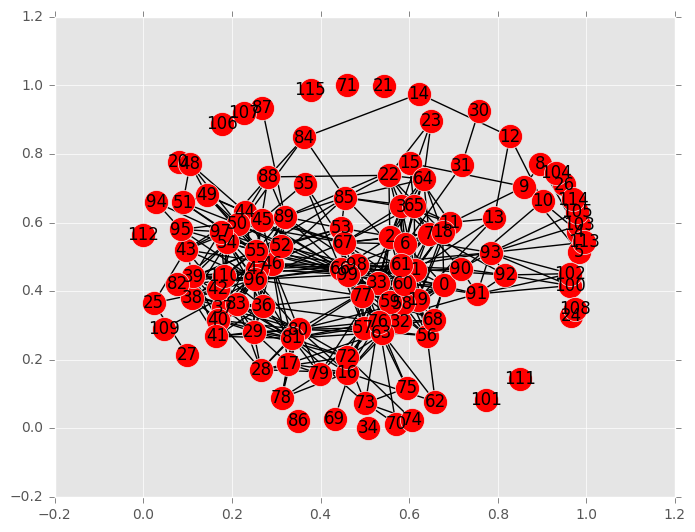

In [13]:
G = nx.from_numpy_matrix(adj_mat)
nx.draw_networkx(G)

Okay, now we want to do this for all the graphs. Here's what we'll do. We'll first threshold everything with some threshold T, then we'll average the graphs, then we'll build this partition.

In [14]:
avg_adj_mat = (correlations > T).astype(int).sum(axis=0) / N

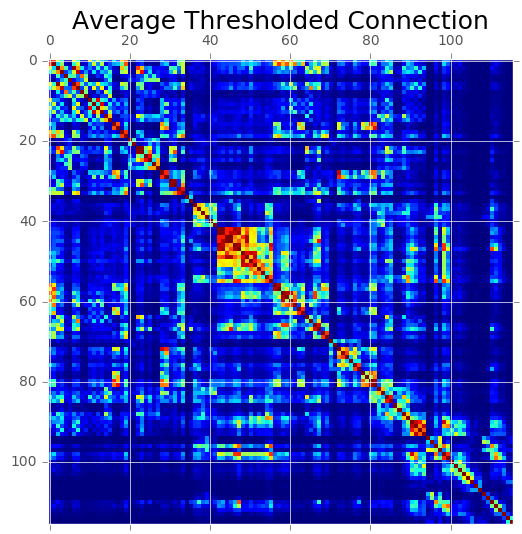

In [15]:
plt.matshow(avg_adj_mat);
plt.title('Average Thresholded Connection');

In [16]:
G_avg = nx.from_numpy_matrix(avg_adj_mat)
partition = community.best_partition(G_avg)

In [17]:
sorted_indices = sorted(range(n),key = lambda k : partition[k]) # sort by partition
sorted_mesh = np.ix_(sorted_indices,sorted_indices) # build an open mesh
plt.matshow(avg_adj_mat[sorted_mesh]);
plt.title('Sorted Average Thresholded Connectivity');

KeyError: 116

Just looking at this thing, I can tell you that we aren't seeing super strong community structure here.

Let's give ourselves a visual aid for looking at these communities:

In [12]:
# find cutoffs between communities
groups = [partition[ind] for ind in sorted_indices]
cuts = []
for index,value in enumerate(groups):
    if value > groups[index-1]:
        cuts.append(index-1)        

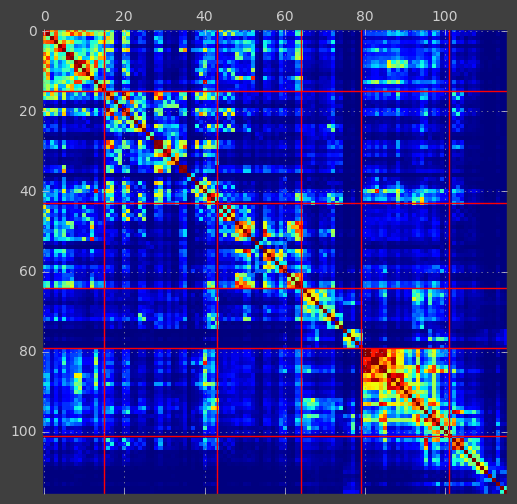

In [13]:
plt.matshow(avg_adj_mat[sorted_mesh]);
for cut in cuts:
    plt.axvline(cut,linewidth=1,color="red")
    plt.axhline(cut,linewidth=1,color="red")

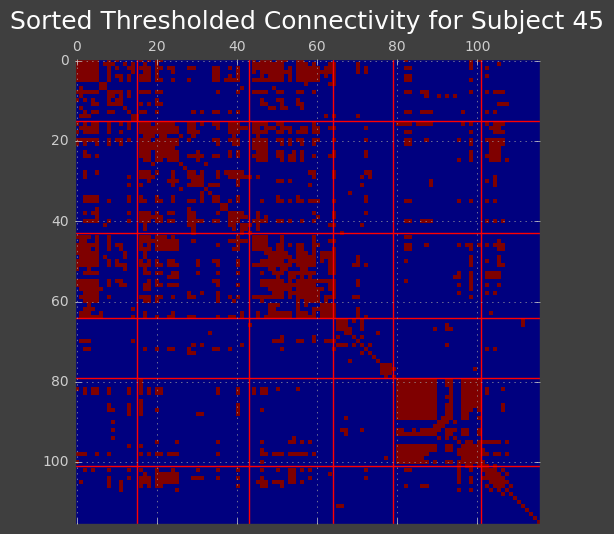

In [14]:
ii = random.choice(range(n))
thresholded = correlations[ii,:] > T
plt.matshow(thresholded[sorted_mesh]);
plt.title('Sorted Thresholded Connectivity for Subject {}'.format(ii));
for cut in cuts:
    plt.axvline(cut,linewidth=1,color="red")
    plt.axhline(cut,linewidth=1,color="red")


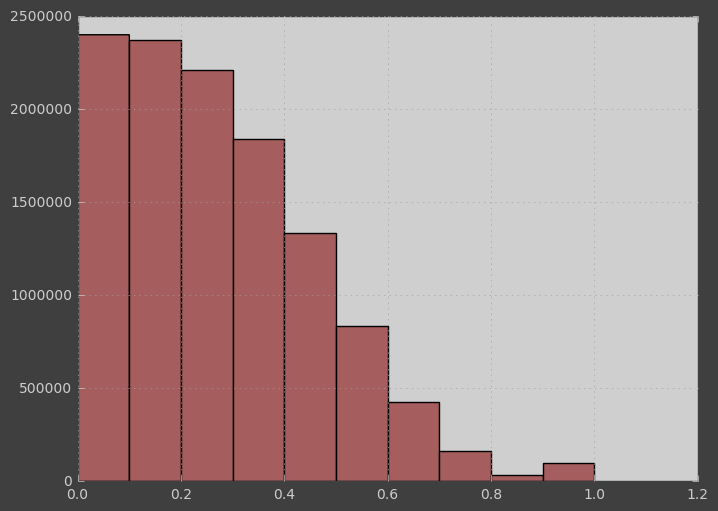

In [15]:
plt.hist(correlations.flatten());

## How do these change over different thresholds?

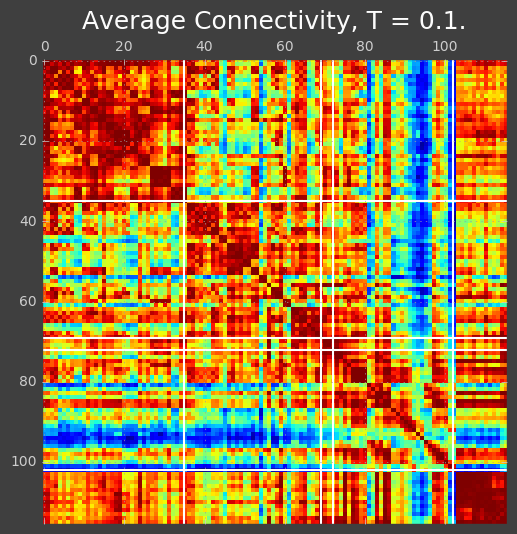

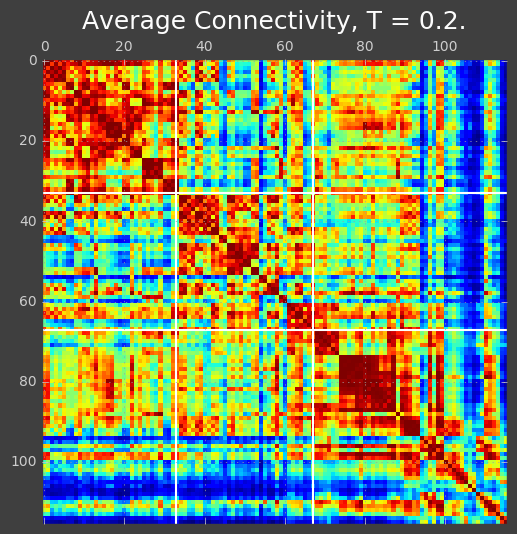

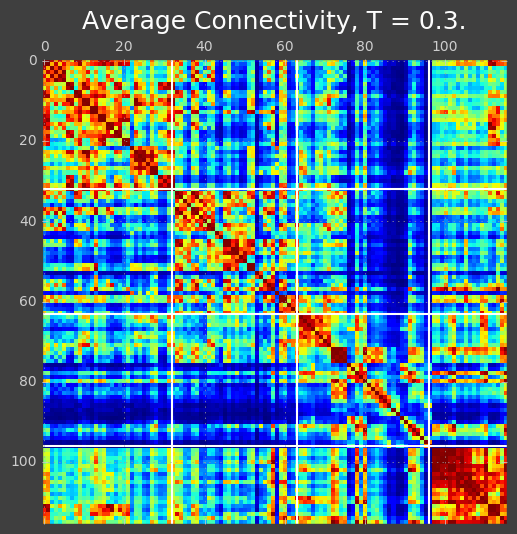

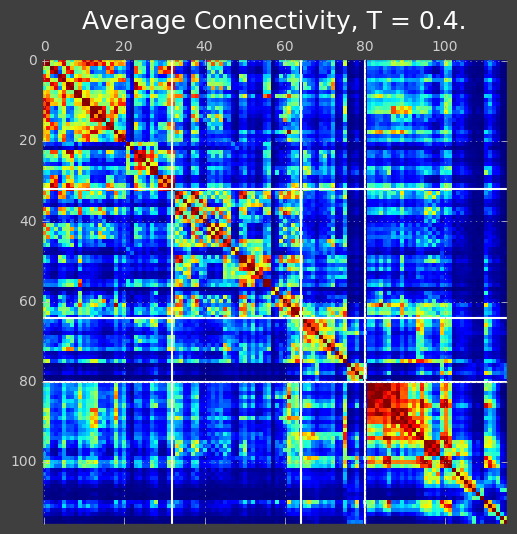

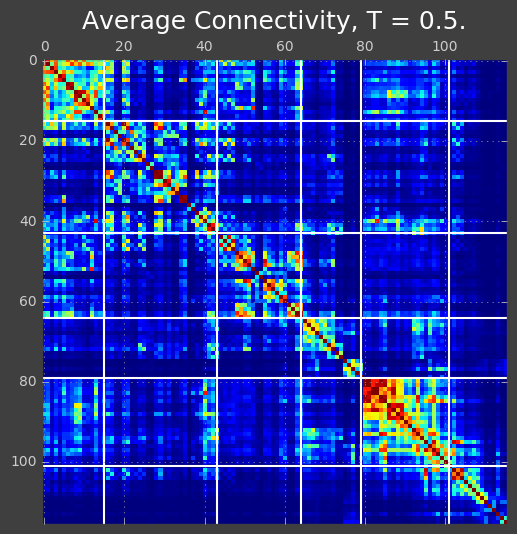

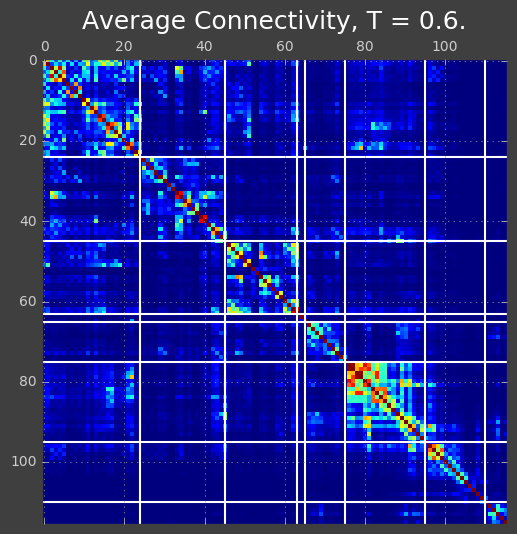

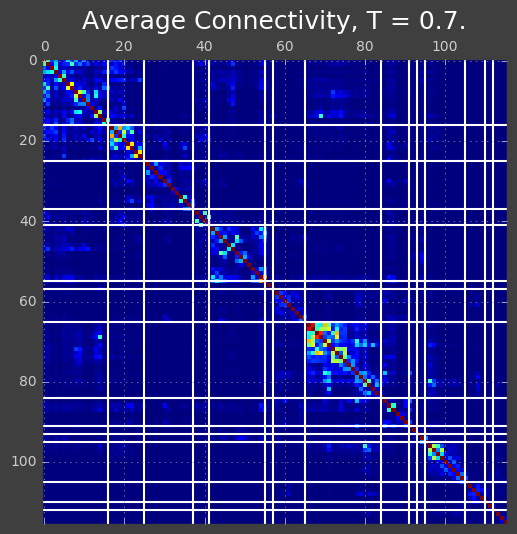

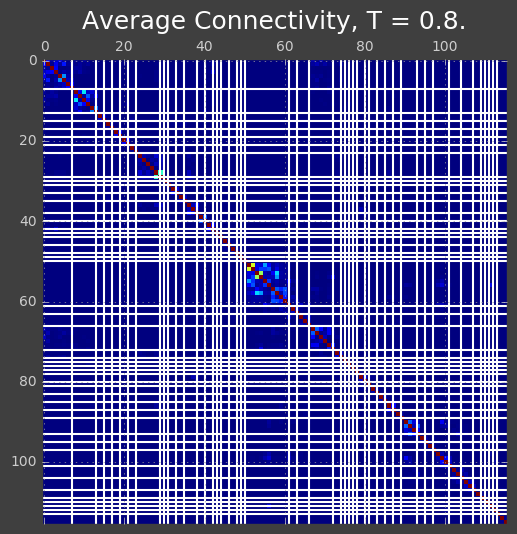

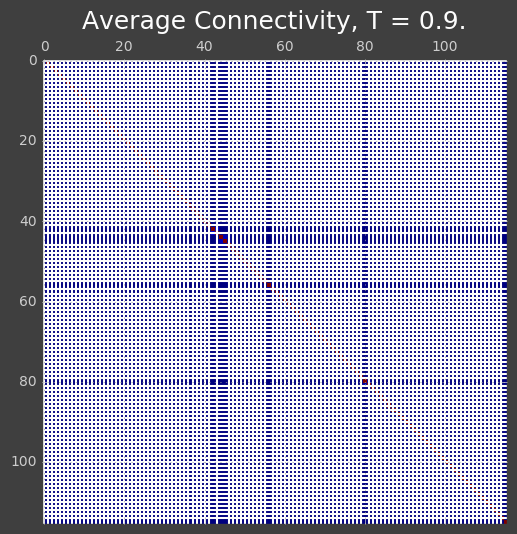

In [51]:
for T in np.arange(0.1,1,0.1):
    avg_adj_mat = (correlations > T).astype(int).sum(axis=0) / N
    G_avg = nx.from_numpy_matrix(avg_adj_mat)
    partition = community.best_partition(G_avg)
    sorted_indices = sorted(range(n),key = lambda k : partition[k]) # sort by partition
    sorted_mesh = np.ix_(sorted_indices,sorted_indices) # build an open mesh
    # find cutoffs between communities
    groups = [partition[ind] for ind in sorted_indices]
    cuts = []
    for index,value in enumerate(groups):
        if value > groups[index-1]:
            cuts.append(index-1)
    plt.figure();
    plt.matshow(avg_adj_mat[sorted_mesh]);
    for cut in cuts:
        plt.axvline(cut,linewidth=1.5,color="white");
        plt.axhline(cut,linewidth=1.5,color="white");
    plt.title('Average Connectivity, T = {:0.1f}.'.format(T));

Looks like we might want to work at a threshold of $T=0.3$ or so to get graphs that can be analyzed using our tools.

What percentage of these graphs are connected?

In [ ]:
T_range = np.arange(0.1,1,0.1)
connection_data = pd.Series(index=T_range)
for T in T_range:
    connection_list = []
    for adj_mat in list(correlations):
        adj_mat = (adj_mat>T).astype(int)
        G = nx.from_numpy_matrix(adj_mat)
        connection_list.append(nx.is_connected(G))
    connection_data[T] = sum(connection_list) / len(connection_list)

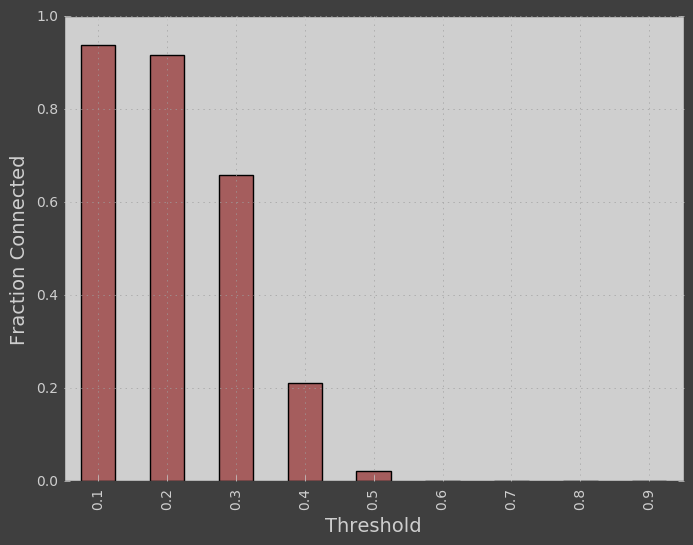

In [49]:
connection_data.plot.bar();
plt.xlabel('Threshold');
plt.ylabel('Fraction Connected');

Yeah, it's looking like $T=0.3$ is the sweet spot for us.

Note that we don't repeat this analysis below; weighting the graph has no effect on this property.

# Weighted Graphs

What if we threshold, but do not set the remaining edges to weight 1? That is to say, we let the edges have weight corresponding to the magnitude of the observed correlation. Let's take a look at what we see in this case.

In [28]:
correlations = np.abs(data['correlation'])
diagnoses = data['diagnosis'] - 1

In [40]:
corr_mat = correlations[1,:,:]
# np.where masks the matrix for us
masked = np.where(corr_mat>T,corr_mat,np.zeros(corr_mat.shape))

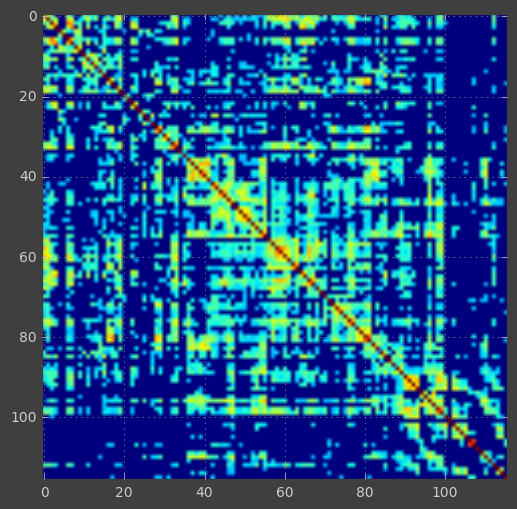

In [42]:
plt.imshow(masked);

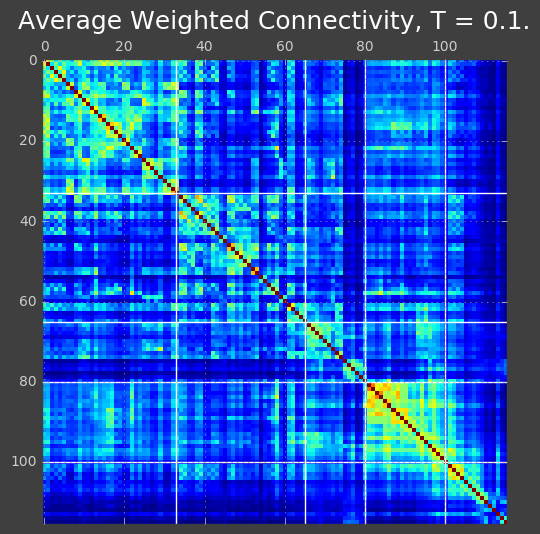

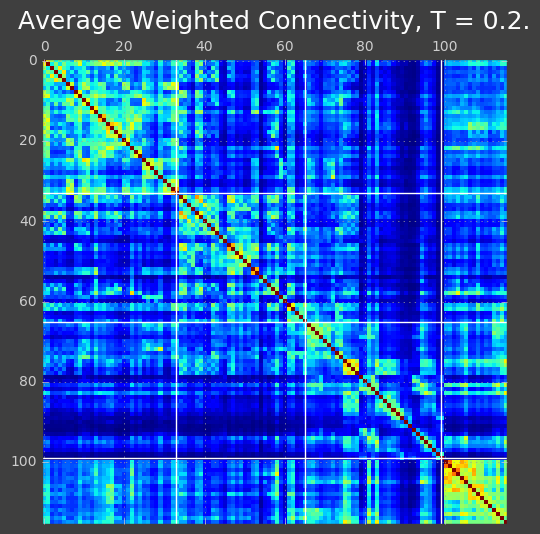

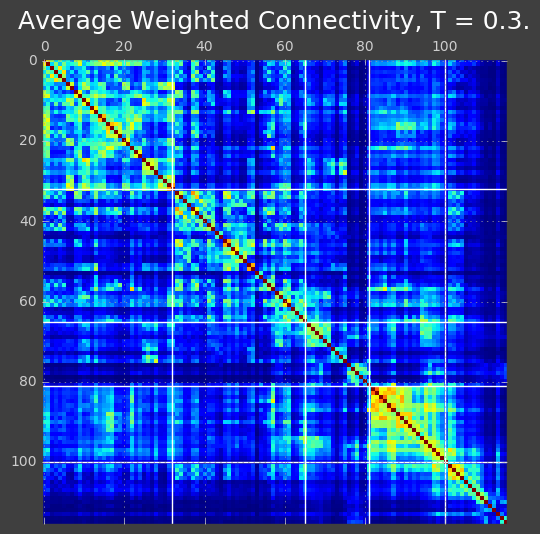

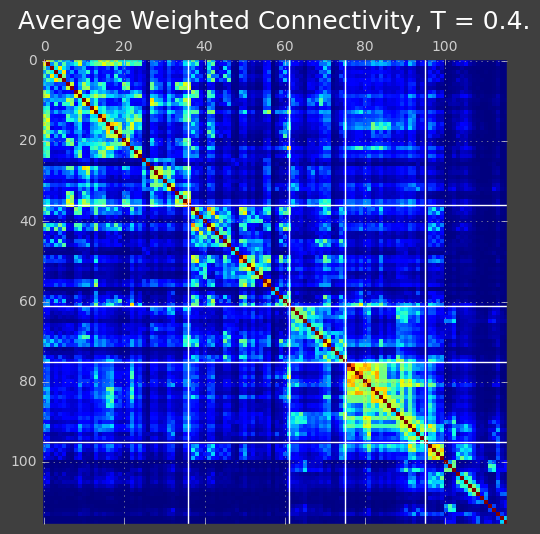

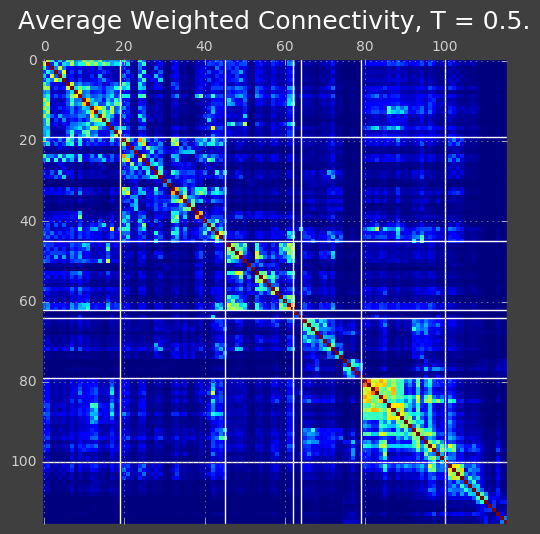

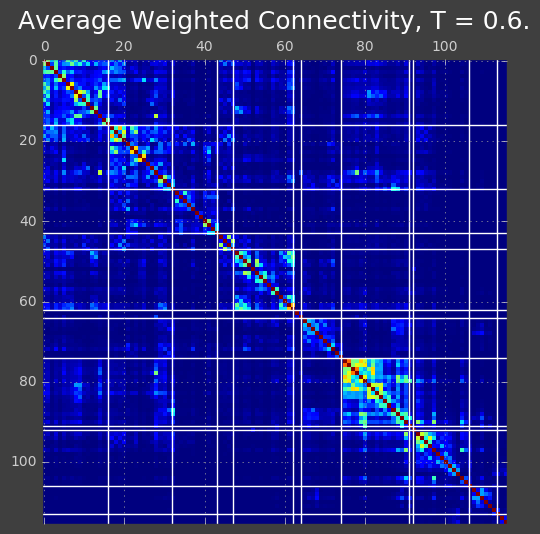

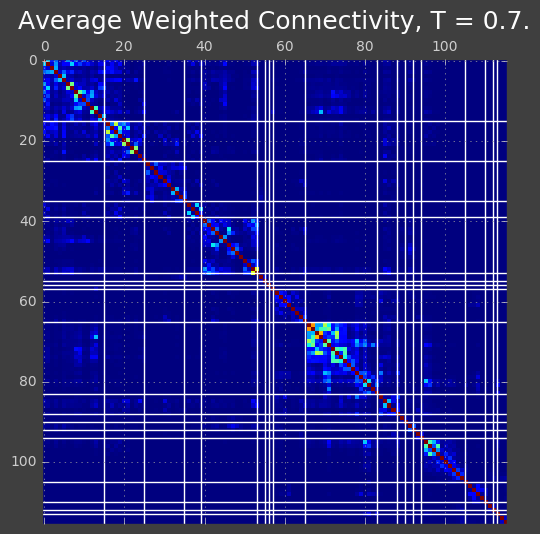

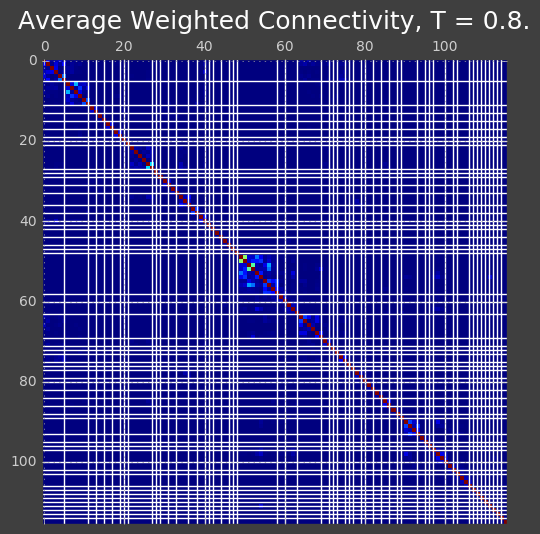

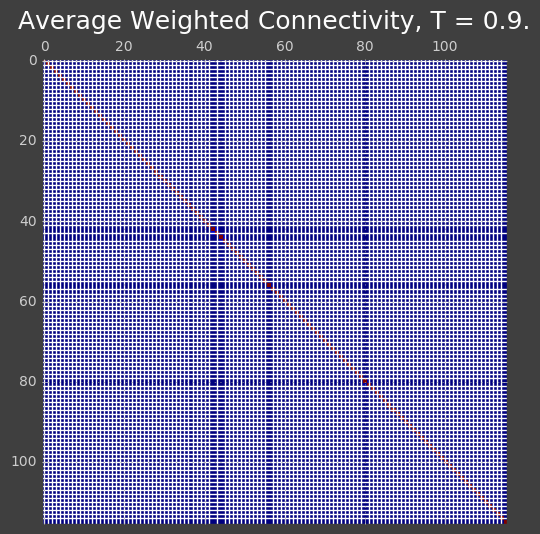

In [43]:
for T in np.arange(0.1,1,0.1):
    masked_correlations = np.where(correlations>T,correlations,np.zeros(correlations.shape))
    avg_adj_mat = masked_correlations.sum(axis=0) / N
    G_avg = nx.from_numpy_matrix(avg_adj_mat)
    partition = community.best_partition(G_avg)
    sorted_indices = sorted(range(n),key = lambda k : partition[k]) # sort by partition
    sorted_mesh = np.ix_(sorted_indices,sorted_indices) # build an open mesh
    # find cutoffs between communities
    groups = [partition[ind] for ind in sorted_indices]
    cuts = []
    for index,value in enumerate(groups):
        if value > groups[index-1]:
            cuts.append(index-1)
    plt.figure();
    plt.matshow(avg_adj_mat[sorted_mesh]);
    for cut in cuts:
        plt.axvline(cut,linewidth=1,color="white");
        plt.axhline(cut,linewidth=1,color="white");
    plt.title('Average Weighted Connectivity, T = {:0.1f}.'.format(T));

### Next Steps: Try looking at community structure in healthy individuals. And figure out how to set the parameter $\beta$ so that we can start measuring resistance distance between these bad boys!